In [ ]:
#from google.colab import files
#files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d tmdb/tmdb-movie-metadata

100% 8.89M/8.89M [00:01<00:00, 6.23MB/s]



In [4]:
import zipfile
zip_ref = zipfile.ZipFile('tmdb-movie-metadata.zip','r')
zip_ref.extractall('files')
zip_ref.close()

In [5]:
import json
import pandas as pd 
import numpy as np 
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud



## Loading the data
The TMDb data includes several nested json fields, so loading the data requires an extra step beyond reading the csv files.

In [6]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [7]:
movies = load_tmdb_movies('/content/files/tmdb_5000_movies.csv')
credits = load_tmdb_credits('/content/files/tmdb_5000_credits.csv')

In [8]:
print(movies.shape)
print(credits.shape)

(4803, 20)
(4803, 4)


In [9]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [10]:
credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."


##Working with the json fields

As we've seen, almost all of the data in the credits file is actually nested json. Since we've loaded the json fields properly, theose fields can be accessed just like any other list or dictionary.

The cast field contains the following keys:

In [11]:
print(sorted(credits.cast.iloc[0][0].keys()))

['cast_id', 'character', 'credit_id', 'gender', 'id', 'name', 'order']


The crew field contains the following keys:

In [12]:
print(sorted(credits.crew.iloc[0][0].keys()))

['credit_id', 'department', 'gender', 'id', 'job', 'name']


The keywords field contains the following keys

In [13]:
print(sorted(movies.keywords.iloc[0][0].keys()))

['id', 'name']


The genres field contains the following keys

In [14]:
print(sorted(movies.genres.iloc[0][0].keys()))

['id', 'name']


The  production_companies contains the following keys

In [15]:
print(sorted(movies.production_companies.iloc[0][0].keys()))

['id', 'name']


The production_countries contains the following keys

In [16]:
print(sorted(movies.production_countries.iloc[0][0].keys()))

['iso_3166_1', 'name']


The spoken_languages contains the following keys

In [17]:
print(sorted(movies.spoken_languages.iloc[0][0].keys()))

['iso_639_1', 'name']


the cast and crew lists are already sorted by the order of appeareance in the film's credits. For example, we can get the names of the first five actors in Avatar with

In [18]:
[actor['name'] for actor in credits['cast'].iloc[0][:5]]

['Sam Worthington',
 'Zoe Saldana',
 'Sigourney Weaver',
 'Stephen Lang',
 'Michelle Rodriguez']

In [19]:
def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

In [20]:
credits['gender_of_lead'] = credits.cast.apply(lambda x: safe_access(x, [0, 'gender']))
credits['lead'] = credits.cast.apply(lambda x: safe_access(x, [0, 'name']))
credits.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


,movie_id,title,cast,crew,gender_of_lead,lead
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",2.0,Sam Worthington
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",2.0,Johnny Depp
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",2.0,Daniel Craig
3,49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",2.0,Christian Bale
4,49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",2.0,Taylor Kitsch


I will merge the two dataset 

In [21]:
credits.columns = ['id','tittle','cast','crew', 'gender_of_lead','lead']
df= movies.merge(credits,on='id')

Now we can create a new column for the gender. It's trinary data ({other: 0, female: 1, male: 2}), but that's the best we can do with the data on hand

In [22]:
credits.gender_of_lead.value_counts()

2.0    3329
1.0    1167
0.0     264
Name: gender_of_lead, dtype: int64

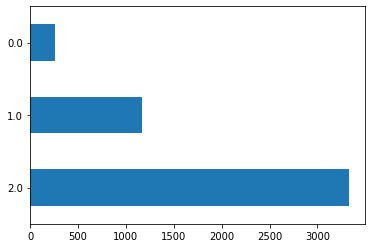

In [23]:
credits['gender_of_lead'].value_counts().plot(kind='barh')

gender disparity,  Men are the lead in most of the movies



In [24]:
credits.rename(columns={'movie_id': 'id', 'crew': 'Director'}, inplace=True)

In [25]:
df = pd.merge(movies, credits,on="id")

In [26]:
df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,Director,gender_of_lead,lead
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",2.0,Sam Worthington
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",2.0,Johnny Depp


In [27]:
# info on variable types and filling factor
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,Director,gender_of_lead,lead
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,object,object,object,float64,object
null values,0,0,3091,0,0,0,0,3,0,0,0,1,0,2,0,0,844,0,0,0,0,0,0,43,43
null values (%),0,0,64.3556,0,0,0,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0,0,0,0.895274,0.895274


In [28]:
df.shape

(4803, 25)

I will drop homepage column because of the high percentage of null values, I will also drop tittle, tiltle column because it is the same with original_title column

In [29]:
df.drop(['homepage','tittle','title'],axis=1,inplace=True)

In [30]:
df.shape

(4803, 22)

In [31]:
df.sample(5)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,cast,Director,gender_of_lead,lead
1082,55000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",2207,"[{'id': 3045, 'name': 'mission of murder'}, {'...",en,16 Blocks,An aging cop is assigned the ordinary task of ...,32.310220,"[{'name': 'Donners' Company', 'id': 431}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-03-01,65664721,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"For a New York cop and his witness, the distan...",6.2,661,"[{'cast_id': 14, 'character': 'Jack Mosley', '...","[{'credit_id': '52fe4341c3a36847f804620f', 'de...",2.0,Bruce Willis
912,60000000,"[{'id': 27, 'name': 'Horror'}, {'id': 10749, '...",628,"[{'id': 90, 'name': 'paris'}, {'id': 582, 'nam...",en,Interview with the Vampire,"A vampire relates his epic life story of love,...",50.163785,"[{'name': 'Geffen Pictures', 'id': 360}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1994-11-11,223664608,123.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Drink from me and live forever,7.2,1516,"[{'cast_id': 18, 'character': 'Louis de Pointe...","[{'credit_id': '52fe4260c3a36847f80199bf', 'de...",2.0,Brad Pitt
2026,22000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",1642,"[{'id': 1332, 'name': 'cheating'}, {'id': 2547...",en,The Net,Angela Bennett is a freelance software enginee...,23.218144,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-07-28,110627965,114.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"No driver's license, no credit cards, no passp...",5.6,354,"[{'cast_id': 1, 'character': 'Angela Bennett/R...","[{'credit_id': '52fe4307c3a36847f80351b3', 'de...",1.0,Sandra Bullock
922,50000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",13811,"[{'id': 843, 'name': 'cataclysm'}, {'id': 4950...",en,Knowing,A teacher opens a time capsule that has been d...,32.693093,"[{'name': 'Summit Entertainment', 'id': 491}, ...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2009-03-19,155446362,121.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Knowing is everything...,5.9,1486,"[{'cast_id': 2, 'character': 'John Koestler', ...","[{'credit_id': '52fe45a49251416c7505d793', 'de...",2.0,Nicolas Cage
550,73000000,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",153518,"[{'id': 2041, 'name': 'island'}, {'id': 2646, ...",en,The Angry Birds Movie,"An island populated entirely by happy, flightl...",45.720894,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'FI', 'name': 'Finland'}, {'is...",2016-05-11,349779543,97.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Why so angry?,5.9,1022,"[{'cast_id': 8, 'character': 'Red (voice)', 'c...","[{'credit_id': '55258c23925141118a00059a', 'de...",2.0,Jason Sudeikis


drop revenues that are smaller and equal to zero

In [32]:
df=df[df.revenue>0]

In [33]:
df.shape

(3376, 22)

getting date information

In [34]:
df.release_date = pd.to_datetime(df.release_date,  errors='coerce')
df['Year'] = df.release_date.dt.year
df['month'] = df.release_date.dt.month
df['weekday'] = df.release_date.dt.weekday

DATA BUDGET, REVENUE AND PROFIT IN YEARS

In [35]:
df['profit'] = df['revenue'] - df['budget']
df['profit_rate'] = df['profit'] / df['budget']

In [36]:
revenues = df.groupby('Year')['revenue'].sum()
budgets = df.groupby('Year')['budget'].sum()
profits = df.groupby('Year')['profit'].sum()

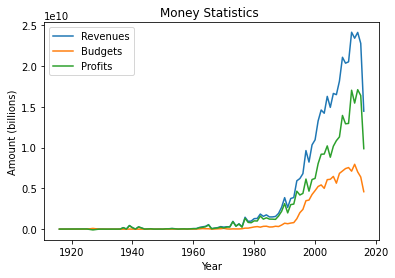

In [37]:
x1 = df['Year']
y1 = revenues
# plotting the revenue points 
plt.plot(revenues, label = "Revenues")
# line 2 points
x2 = df['Year']
y2 = budgets
# plotting the budgets points 
plt.plot(budgets, label = "Budgets")
x3 = df['Year']
y3 = profits
# plotting the profits points 
plt.plot(profits, label = "Profits")
plt.xlabel('Year')
# Set the y axis label of the current axis.
plt.ylabel('Amount (billions)')
# Set a title of the current axes.
plt.title('Money Statistics ')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

#The revenue peak is in 2012, let check out the movies

In [38]:
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

In [39]:
df0 = df.copy()

In [40]:
df0['genres'] = df0['genres'].apply(pipe_flatten_names)

In [41]:
df0['production_countries'] = df0['production_countries'].apply(pipe_flatten_names)

In [42]:
df0['production_companies'] = df0['production_companies'].apply(pipe_flatten_names)

In [43]:
df0['Director'] = df0['Director'].apply(pipe_flatten_names)

In [44]:
top_10 = df0[df0['Year'] == 2012]
top_10.sort_values(by="revenue", ascending=False)[['original_title', 'budget', 'revenue', 'profit', 'genres','gender_of_lead','lead','production_countries','production_companies']].head(10)

,original_title,budget,revenue,profit,genres,gender_of_lead,lead,production_countries,production_companies
16,The Avengers,220000000,1519557910,1299557910,Science Fiction|Action|Adventure,2.0,Robert Downey Jr.,United States of America,Paramount Pictures|Marvel Studios
29,Skyfall,200000000,1108561013,908561013,Action|Adventure|Thriller,2.0,Daniel Craig,United Kingdom|United States of America,Columbia Pictures
3,The Dark Knight Rises,250000000,1084939099,834939099,Action|Crime|Drama|Thriller,2.0,Christian Bale,United States of America,Legendary Pictures|Warner Bros.|DC Entertainme...
98,The Hobbit: An Unexpected Journey,250000000,1021103568,771103568,Adventure|Fantasy|Action,2.0,Ian McKellen,New Zealand|United States of America,WingNut Films|New Line Cinema|Warner Bros. Pic...
325,Ice Age: Continental Drift,95000000,877244782,782244782,Animation|Comedy|Adventure|Family,2.0,John Leguizamo,United States of America,Blue Sky Studios|Twentieth Century Fox Animation
172,The Twilight Saga: Breaking Dawn - Part 2,120000000,829000000,709000000,Adventure|Fantasy|Drama|Romance,1.0,Kristen Stewart,United States of America,Summit Entertainment|Sunswept Entertainment|Te...
20,The Amazing Spider-Man,215000000,752215857,537215857,Action|Adventure|Fantasy,2.0,Andrew Garfield,United States of America,Columbia Pictures|Laura Ziskin Productions|Mar...
146,Madagascar 3: Europe's Most Wanted,145000000,746921274,601921274,Animation|Family,2.0,Ben Stiller,United States of America,DreamWorks Animation
426,The Hunger Games,75000000,691210692,616210692,Science Fiction|Adventure|Fantasy,1.0,Jennifer Lawrence,United States of America,Lionsgate|Color Force
18,Men in Black 3,225000000,624026776,399026776,Action|Comedy|Science Fiction,2.0,Will Smith,United States of America,Amblin Entertainment|Media Magik Entertainment...


##The profit peak is in 2012 & 2014, let check out the top proftitable movies in 2014

In [45]:
top_10 = df0[df0['Year'] == 2014]
top_10.sort_values(by="profit", ascending=False)[['original_title', 'budget', 'revenue', 'profit', 'genres','gender_of_lead','lead','production_countries','production_companies']].head(10)

,original_title,budget,revenue,profit,genres,gender_of_lead,lead,production_countries,production_companies
36,Transformers: Age of Extinction,210000000,1091405097,881405097,Science Fiction|Action|Adventure,2.0,Mark Wahlberg,United States of America,Paramount Pictures|Amblin Entertainment|Di Bon...
19,The Hobbit: The Battle of the Five Armies,250000000,956019788,706019788,Action|Adventure|Fantasy,2.0,Martin Freeman,New Zealand|United States of America,WingNut Films|New Line Cinema|Warner Bros. Pic...
200,The Hunger Games: Mockingjay - Part 1,125000000,752100229,627100229,Science Fiction|Adventure|Thriller,1.0,Jennifer Lawrence,United States of America,Lionsgate|Color Force
94,Guardians of the Galaxy,170000000,773328629,603328629,Action|Science Fiction|Adventure,2.0,Chris Pratt,United Kingdom|United States of America,Marvel Studios|Moving Picture Company (MPC)|Bu...
81,Maleficent,180000000,758539785,578539785,Fantasy|Adventure|Action|Family|Romance,1.0,Angelina Jolie,United States of America,Walt Disney Pictures|Walt Disney Studios Motio...
85,Captain America: The Winter Soldier,170000000,714766572,544766572,Action|Adventure|Science Fiction,2.0,Chris Evans,United States of America,Marvel Studios
82,Dawn of the Planet of the Apes,170000000,710644566,540644566,Science Fiction|Action|Drama|Thriller,2.0,Andy Serkis,United States of America,Ingenious Media|Chernin Entertainment|TSG Ente...
95,Interstellar,165000000,675120017,510120017,Adventure|Drama|Science Fiction,2.0,Matthew McConaughey,Canada|United States of America|United Kingdom,Paramount Pictures|Legendary Pictures|Warner B...
38,The Amazing Spider-Man 2,200000000,705717432,505717432,Action|Adventure|Fantasy,2.0,Andrew Garfield,United States of America,Columbia Pictures|Marvel Enterprises|Avi Arad ...
46,X-Men: Days of Future Past,250000000,747862775,497862775,Action|Adventure|Fantasy|Science Fiction,2.0,Hugh Jackman,United Kingdom|United States of America,Twentieth Century Fox Film Corporation|Donners...


##The movies with most profit rate

In [46]:
sub_data = df0[(df0['budget'] != 0) & (df0['revenue'] != 0) & (df0['budget'] > 10000000)]
sub_data.sort_values(by='profit_rate', ascending=False)[['original_title', 'budget', 'revenue', 'profit', 'genres','gender_of_lead','lead','production_countries','production_companies']].head(10)

,original_title,budget,revenue,profit,genres,gender_of_lead,lead,production_countries,production_companies
2967,E.T. the Extra-Terrestrial,10500000,792910554,782410554,Science Fiction|Adventure|Family|Fantasy,0.0,Henry Thomas,United States of America,Universal Pictures|Amblin Entertainment
2912,Star Wars,11000000,775398007,764398007,Adventure|Action|Science Fiction,2.0,Mark Hamill,United States of America,Lucasfilm|Twentieth Century Fox Film Corporation
2668,Pretty Woman,14000000,463000000,449000000,Romance|Comedy,1.0,Julia Roberts,United States of America,Touchstone Pictures|Silver Screen Partners IV
1990,The Empire Strikes Back,18000000,538400000,520400000,Adventure|Action|Science Fiction,2.0,Mark Hamill,United States of America,Lucasfilm|Twentieth Century Fox Film Corporation
2517,The King's Speech,15000000,414211549,399211549,Drama|History,2.0,Colin Firth,United Kingdom,The Weinstein Company|UK Film Council|Bedlam P...
2511,Home Alone,18000000,476684675,458684675,Comedy|Family,2.0,Macaulay Culkin,United States of America,Twentieth Century Fox Film Corporation|Hughes ...
2838,The Fault in Our Stars,12000000,307166834,295166834,Romance|Drama,1.0,Shailene Woodley,United States of America,Fox 2000 Pictures|Temple Hill Entertainment|TS...
2730,Black Swan,13000000,327803731,314803731,Drama|Thriller,1.0,Natalie Portman,United States of America,Fox Searchlight Pictures|Dune Entertainment|Pr...
2666,Slumdog Millionaire,15000000,377910544,362910544,Drama|Romance,2.0,Dev Patel,India|United Kingdom|United States of America,Fox Searchlight Pictures|Celador Films|Warner ...
2096,The Conjuring,13000000,318000141,305000141,Horror|Thriller,2.0,Patrick Wilson,United States of America,New Line Cinema|The Safran Company|Evergreen M...


we will need a metric score to rate our movie

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :

$$(\dfrac{v}{v+m}.R)+(\dfrac{m}{v+m}.C)$$

where,

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

We already have v(vote_count) and R (vote_average) and C can be calculated as

In [47]:
C= df['vote_average'].mean()
C

6.3087381516587575

So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [48]:
m= df['vote_count'].quantile(0.9)
m

2429.0

In [49]:
q_movies = df.copy().loc[df['vote_count'] >= m]
q_movies.shape

(338, 27)

In [50]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [51]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

##Top 15 movies

In [52]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['original_title', 'vote_count', 'vote_average', 'score']].head(10)

,original_title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,7.999476
662,Fight Club,9413,8.3,7.891558
65,The Dark Knight,12002,8.2,7.881666
3232,Pulp Fiction,8428,8.3,7.854502
96,Inception,13752,8.1,7.831106
3337,The Godfather,5893,8.4,7.789609
95,Interstellar,10867,8.1,7.772761
809,Forrest Gump,7927,8.2,7.756404
329,The Lord of the Rings: The Return of the King,8064,8.1,7.685345
1990,The Empire Strikes Back,5879,8.2,7.647054


I will visualize the most popular movies 

Text(0.5, 1.0, 'Popular Movies')

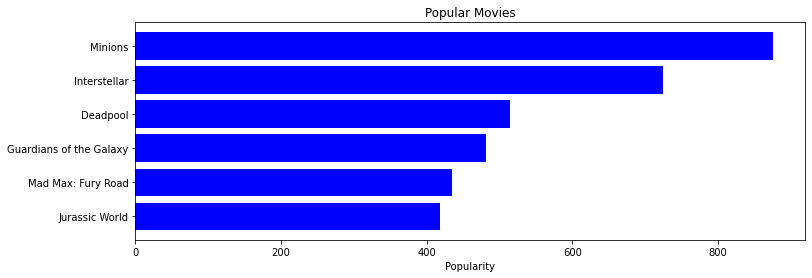

In [53]:
pop= df.sort_values('popularity', ascending=False)

plt.figure(figsize=(12,4))

plt.barh(pop['original_title'].head(6),pop['popularity'].head(6), align='center',color='blue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

##Keywords
The keywords describes the films. Indeed, a basic assumption is that films described by similar keywords should have similar contents

In [54]:
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

In [55]:
keywords = df.copy()

In [56]:
keywords['keywords'] = keywords['keywords'].apply(pipe_flatten_names)

In [57]:
keywords['keywords']

0       culture clash|future|space war|space colony|so...
1       ocean|drug abuse|exotic island|east india trad...
2       spy|based on novel|secret agent|sequel|mi6|bri...
3       dc comics|crime fighter|terrorist|secret ident...
4       based on novel|mars|medallion|space travel|pri...
                              ...                        
4775                                           mumblecore
4788    gay|trailer park|pop culture|drug dealer|heroi...
4792    japan|prostitute|hotel|based on novel|hallucin...
4796    distrust|garage|identity crisis|time travel|ti...
4798    united states–mexico barrier|legs|arms|paper k...
Name: keywords, Length: 3376, dtype: object

In [58]:
set_keywords = set()
for liste_keywords in keywords['keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)

In [59]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [60]:
keyword_occurences, dum = count_word(keywords,'keywords',set_keywords)
keyword_occurences[:5]

[['duringcreditsstinger', 278],
 ['woman director', 185],
 ['based on novel', 179],
 ['aftercreditsstinger', 152],
 ['murder', 143]]

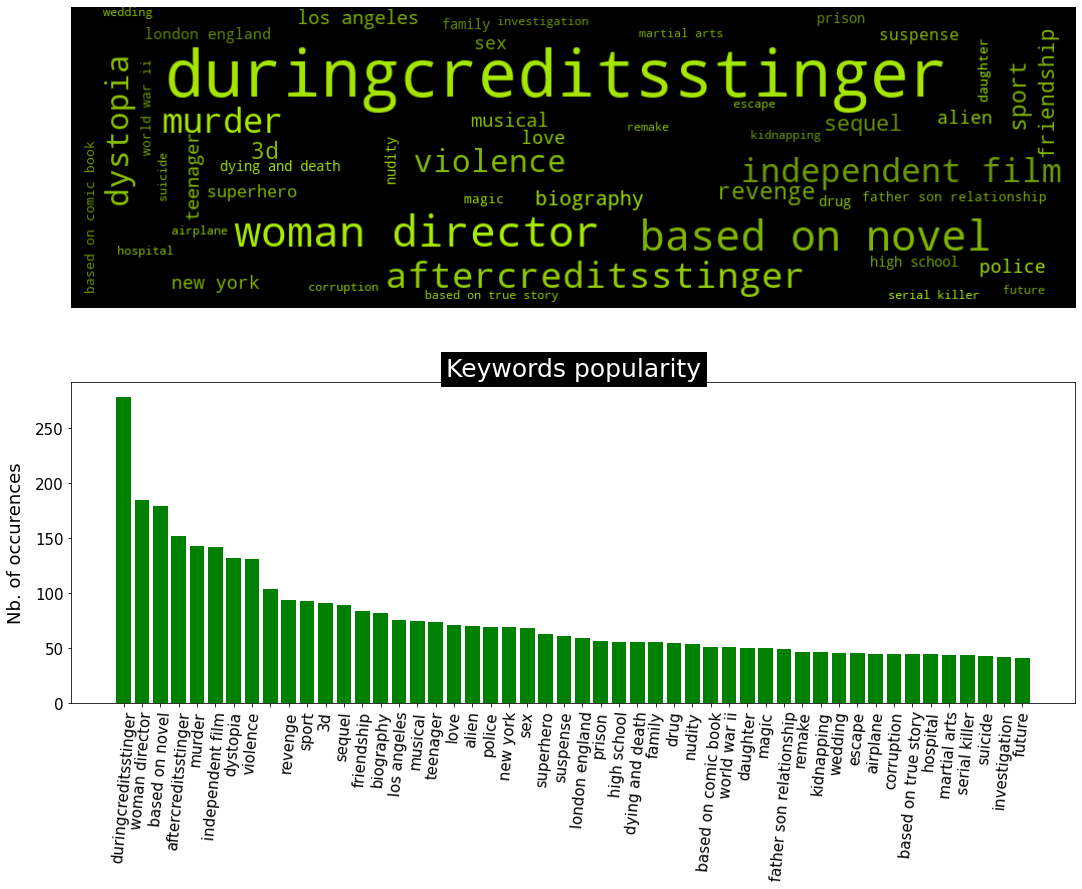

In [61]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#_____________________________________________
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=1000,height=300, background_color='black', max_words=1628,relative_scaling=1,color_func = random_color_func,normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
#_____________________________________________
# LOWER PANEL: HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Keywords popularity",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

##Let's see now the correlation between all these variables among themselves

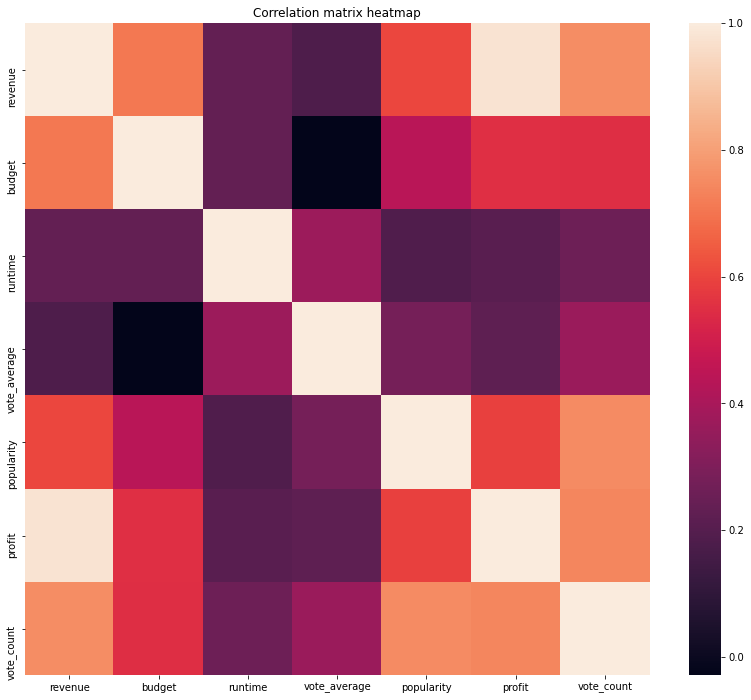

In [62]:
fig, ax = plt.subplots(figsize=(14,12));
new = df[['revenue','budget', 'runtime', 'vote_average', 'popularity','profit','vote_count']].copy()
new = new.corr()
sns.heatmap(new, ax=ax);
ax.set_title('Correlation matrix heatmap');

##I will tidy the credits dataset by flattening out the file untill we have one row per person involved in the movies 

In [63]:
credits = load_tmdb_credits('/content/files/tmdb_5000_credits.csv')

In [64]:
credits.apply(lambda row: [x.update({'title': row['title']}) for x in row['cast']], axis=1);
credits.apply(lambda row: [x.update({'title': row['title']}) for x in row['crew']], axis=1);
credits.apply(lambda row: [person.update({'order': order}) for order, person in enumerate(row['crew'])], axis=1);

cast = []
credits.cast.apply(lambda x: cast.extend(x))
cast = pd.DataFrame(cast)
cast['type'] = 'cast'

crew = []
credits.crew.apply(lambda x: crew.extend(x))
crew = pd.DataFrame(crew)
crew['type'] = 'crew'

people = pd.concat([cast, crew],  ignore_index=True)
people.head()

,cast_id,character,credit_id,gender,id,name,order,title,type,department,job
0,242.0,Jake Sully,5602a8a7c3a3685532001c9a,2,65731,Sam Worthington,0,Avatar,cast,NaN,NaN
1,3.0,Neytiri,52fe48009251416c750ac9cb,1,8691,Zoe Saldana,1,Avatar,cast,NaN,NaN
2,25.0,Dr. Grace Augustine,52fe48009251416c750aca39,1,10205,Sigourney Weaver,2,Avatar,cast,NaN,NaN
3,4.0,Col. Quaritch,52fe48009251416c750ac9cf,2,32747,Stephen Lang,3,Avatar,cast,NaN,NaN
4,5.0,Trudy Chacon,52fe48009251416c750ac9d3,1,17647,Michelle Rodriguez,4,Avatar,cast,NaN,NaN


In [65]:
#I will set the index to title for easy access
people=people.set_index('title')

To get the enire rows of people involved in a particular movie , I will use pandas loc to select the movie

In [66]:
people.loc['Thor']

,cast_id,character,credit_id,gender,id,name,order,type,department,job
title,,,,,,,,,,
Thor,1.0,Thor Odinson,52fe433f9251416c750091e5,2,74568,Chris Hemsworth,0,cast,NaN,NaN
Thor,5.0,Jane Foster,52fe433f9251416c750091f7,1,524,Natalie Portman,1,cast,NaN,NaN
Thor,3.0,Loki,52fe433f9251416c750091ef,2,91606,Tom Hiddleston,2,cast,NaN,NaN
Thor,6.0,Odin,52fe433f9251416c750091fb,2,4173,Anthony Hopkins,3,cast,NaN,NaN
Thor,23.0,Erik Selvig,52fe433f9251416c7500924d,2,1640,Stellan Skarsgård,4,cast,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
Thor,NaN,NaN,569457f4c3a3680eb00009c3,0,1408354,Pete Cavaciuti,25,crew,Camera,Camera Operator
Thor,NaN,NaN,569457ee9251414b6b000857,0,1408354,Pete Cavaciuti,26,crew,Camera,Steadicam Operator
Thor,NaN,NaN,553c29b6925141125600a63c,2,1412756,Chris O'Connell,27,crew,Crew,Visual Effects Editor


In [67]:
people.loc['The Avengers']

,cast_id,character,credit_id,gender,id,name,order,type,department,job
title,,,,,,,,,,
The Avengers,46.0,Tony Stark / Iron Man,52fe4495c3a368484e02b251,2,3223,Robert Downey Jr.,0,cast,NaN,NaN
The Avengers,2.0,Steve Rogers / Captain America,52fe4495c3a368484e02b19b,2,16828,Chris Evans,1,cast,NaN,NaN
The Avengers,32.0,Bruce Banner / The Hulk,52fe4495c3a368484e02b221,2,103,Mark Ruffalo,2,cast,NaN,NaN
The Avengers,4.0,Thor Odinson,52fe4495c3a368484e02b1a5,2,74568,Chris Hemsworth,3,cast,NaN,NaN
The Avengers,34.0,Natasha Romanoff / Black Widow,52fe4495c3a368484e02b229,1,1245,Scarlett Johansson,4,cast,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
The Avengers,NaN,NaN,5534071a92514110140041b1,0,1456696,Brian N. Bentley,142,crew,Crew,Compositors
The Avengers,NaN,NaN,553b29799251412c270007fb,0,1457930,James Baker,143,crew,Visual Effects,Visual Effects
The Avengers,NaN,NaN,553ea6c59251411f40000066,0,1457935,Michael Queen,144,crew,Crew,Compositors


References :

* https://www.kaggle.com/sohier/film-recommendation-engine-converted-to-use-tmdb/comments

* https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system